In [1]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from lmfit import minimize, Parameters, Parameter, report_fit
from numpy import asarray
from numpy import savetxt
import os
import time
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
start = time.time() #Saves the begining time of the process

from Funciones import EstimacionVariables, DifFinitas2

In [2]:
#Variables conocidas del modelo SIR

gamma = 1./21.
fechas = pd.read_csv('Fechas/' + 'Fechas.csv')
#####################################################

depas = pd.read_csv('DEPARTAMENTOS/Departamentos.csv')
NOMBREDEPTO =  depas["Departamentos"]
#####################################################

POSITIVOSDEPTO = [] 
for n in range(len(NOMBREDEPTO)):
    rep_diarios = pd.read_csv('dA/' + NOMBREDEPTO[n] + '_ReporteDiario.csv')
    c = rep_diarios["Reporte_Diario"].values.tolist()
    POSITIVOSDEPTO.append(c)
#####################################################    

acumuladosReportados = [] 
for n in range(len(NOMBREDEPTO)):
    acumulados = pd.read_csv('ACUMULADOS/' + NOMBREDEPTO[n] + '_Acumulados_Reportados.csv')
    c = acumulados["Acumulados_Reportados"].values.tolist()
    acumuladosReportados.append(c)
    
#####################################################    

Poblacion = pd.read_csv('POBLACION/' + 'Poblacion.csv')["Poblacion"].values.tolist()

In [3]:
A, dA, S, I,R, Beta, Rt, R0 = EstimacionVariables(acumuladosReportados, POSITIVOSDEPTO, Poblacion, gamma)

In [4]:
def adfuller_test(serie):
    result=adfuller(serie)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")
    return result

In [5]:
adfuller_test(Beta[0][:587])

ADF Test Statistic : -2.2323215982327143
p-value : 0.19472436633031753
#Lags Used : 15
Number of Observations : 571
weak evidence against null hypothesis,indicating it is non-stationary 


(-2.2323215982327143,
 0.19472436633031753,
 15,
 571,
 {'1%': -3.4418542752662518,
  '5%': -2.8666150225357914,
  '10%': -2.569472836146374},
 -5893.221470735355)

In [6]:
#si quiere de grado 2, aplique dos veces Diferencias con grado=1
#para quitar tendencia y periodicidad
def Diferencias(serie): #grado 1 implicito
    #suponga grado = 1
    #serie = [1,2,3,4,5]
    s1 = np.array(serie[:len(serie)-1]) #[1,2,3,4]
    s2 = np.array(serie[1:])#[2,3,4,5]
    serie_nueva = (s2-s1).tolist()
    return serie_nueva

In [7]:
#serie_nueva = Diferencias(Beta[0][:583])
serie_nueva = Diferencias(Beta[0][:595])


In [8]:
adfuller_test(serie_nueva)

ADF Test Statistic : -7.8230881290973695
p-value : 6.590159748350827e-12
#Lags Used : 14
Number of Observations : 579
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


(-7.8230881290973695,
 6.590159748350827e-12,
 14,
 579,
 {'1%': -3.441694608475642,
  '5%': -2.866544718556839,
  '10%': -2.5694353738653684},
 -5905.326046445853)

In [9]:
#Es un proceso estacionario!
inicio = 586
fin = 690
t= []
for i in range(inicio, fin+1):
    t.append(i)

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


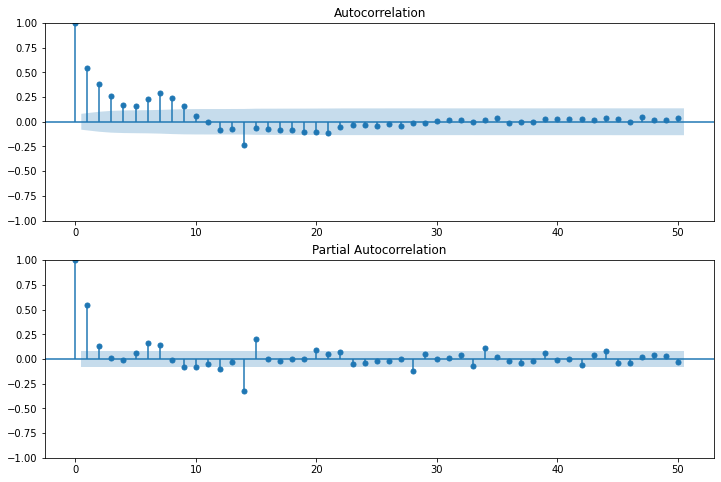

In [10]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(serie_nueva, lags = 50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(serie_nueva, lags = 50,ax=ax2)
plt.savefig('Autocorrelaciones/'+'Autocorrelaciones_SerieNueva_GT_ola1.pdf', bbox_inches = 'tight')


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


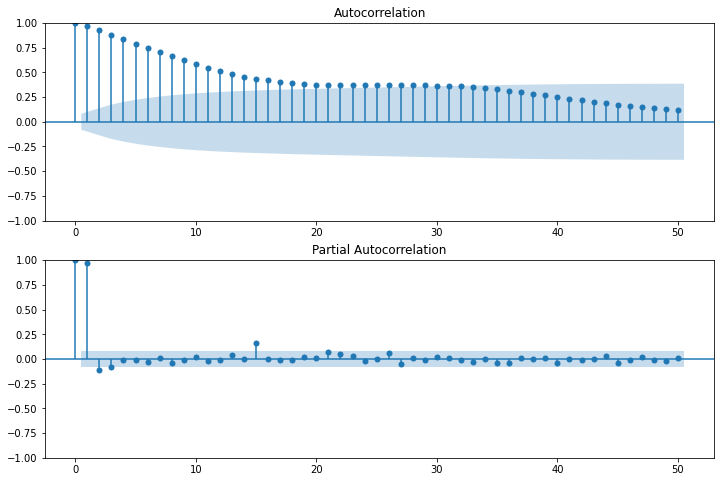

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Beta[0][:583], lags = 50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Beta[0][:583], lags = 50,ax=ax2)
plt.savefig('Autocorrelaciones/'+'Autocorrelaciones_Beta_GT_ola1.pdf', bbox_inches = 'tight')


In [12]:
#p: The number of lag observations included in the model, also called the lag order.
#d: The number of times that the raw observations are differenced, also called the degree of difference.
#q: The size of the moving average window, also called the order of moving average.

In [13]:
def ECM(x,y):
    #y es lo observado
    X = np.array(x)
    Y = np.array(y)
    Z = (X-Y)**2
    return Z.mean()

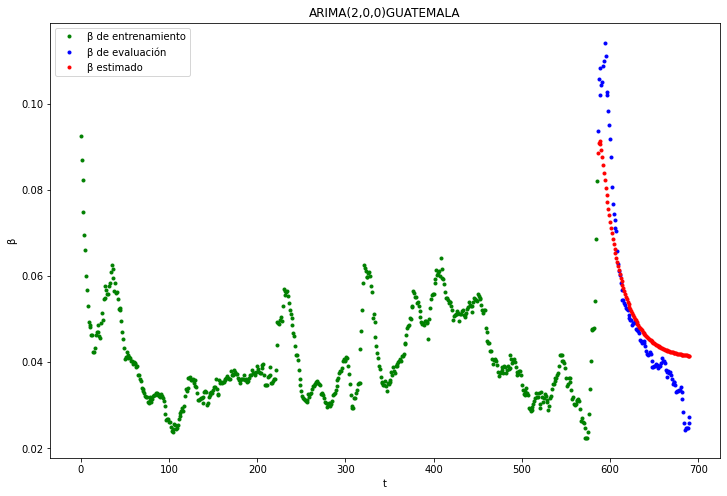

In [14]:
#suponiendo inicio=586
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima.model import ARIMA

p=2
d=0
q = 0
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_sinTransformacion_a.pdf', bbox_inches = 'tight')


In [15]:
np.array(Beta[0][:586]).mean()

0.04089983595848159

In [16]:
forecast[len(forecast)-4:len(forecast)-1]

array([0.04157839, 0.04154911, 0.0415211 ])

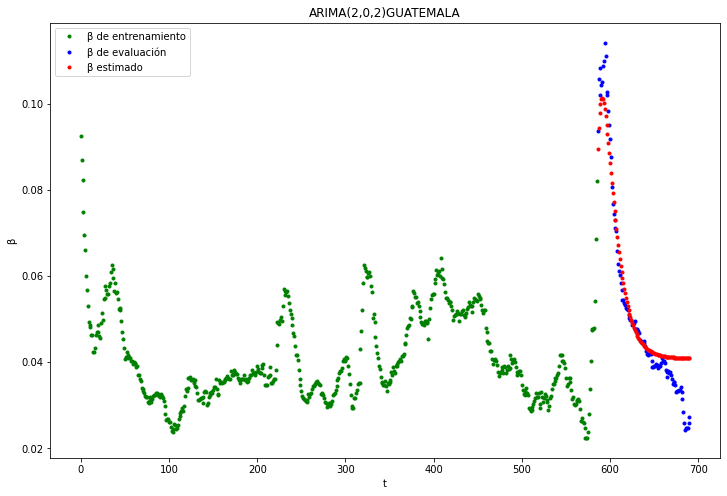

In [17]:
p=2
d=0
q = 2
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_sinTransformacion_b.pdf', bbox_inches = 'tight')


In [18]:
forecast[len(forecast)-4:len(forecast)-1]

array([0.04096042, 0.04095581, 0.04095157])

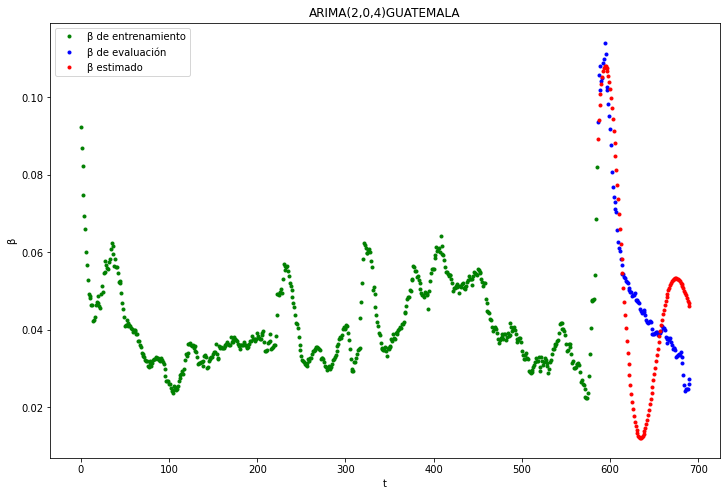

In [19]:
p=2
d=0
q = 4
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_sinTransformacion_c.pdf', bbox_inches = 'tight')


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


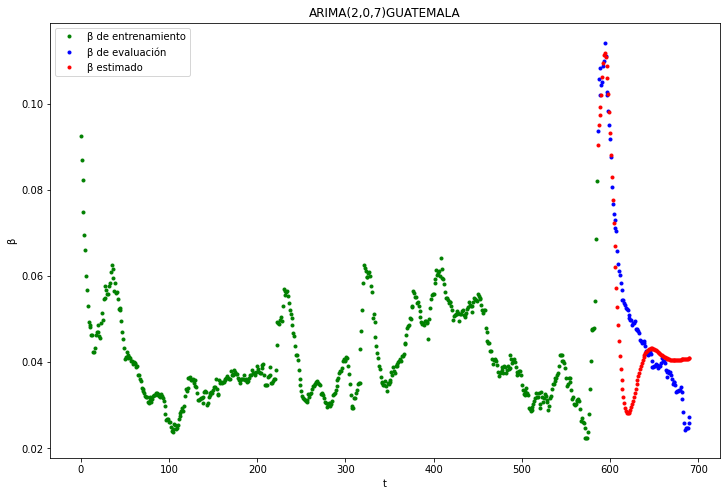

In [20]:
p=2
d=0
q = 7
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_sinTransformacion_d.pdf', bbox_inches = 'tight')


In [21]:
forecast[len(forecast)-4:len(forecast)-1], max(forecast)

(array([0.04082606, 0.0408508 , 0.04087339]), 0.11166804120784106)

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


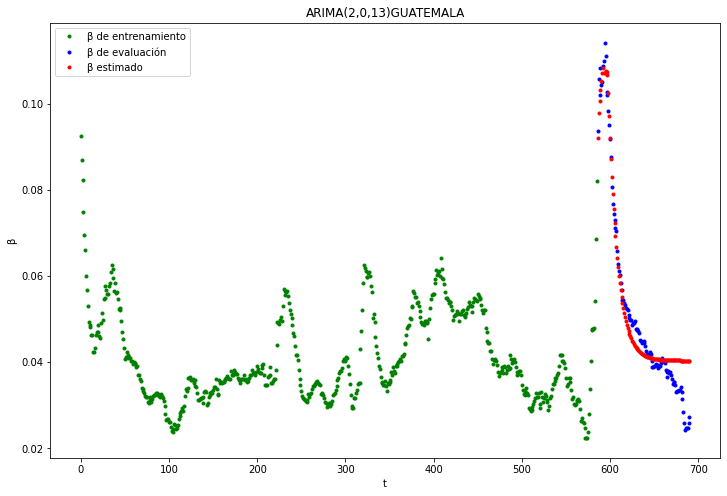

In [22]:
p=2
d=0
q = 13
model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()

forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(Beta[0][:inicio],'g.', label='\u03B2 de entrenamiento')
plt.plot(t, Beta[0][inicio:fin+1], 'b.', label='\u03B2 de evaluación')
plt.plot(t, forecast, 'r.', label='\u03B2 estimado')
plt.xlabel('t')
plt.ylabel('\u03B2')
plt.title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])
plt.legend(loc='best')
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_sinTransformacion_e.pdf', bbox_inches = 'tight')


In [23]:
forecast[len(forecast)-4:len(forecast)-1], max(forecast)

(array([0.04038568, 0.04038458, 0.04038358]), 0.10826180431729374)

In [24]:
#calcular el ECM para solo unos dias, ya que en la practica no conocemas toda la evolución de la curva
p=2
d=0
Q=[]
error = []
print("q", "ECM")
for q in range(0,20):
    model=ARIMA(Beta[0][:inicio],order=(p,d,q)) #d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ecm = ECM(forecast[:10], Beta[0][inicio:inicio+10])
    Q.append(q)
    error.append(ecm)
    print(q, ecm)
    


q ECM
0 0.0004361245229771339
1 0.00013644888888897418
2 8.783268944276072e-05


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


3 0.004074742115271525
4 3.1187306159420954e-05


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5 3.087636785150675e-05
6 3.891769064426157e-05


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7 2.663884350827648e-05


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8 0.00022681772022767238
9 0.00023236115428511528


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10 0.00016336857494683458
11 0.00014806584871253614
12 0.00024107625182560774


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13 2.009987228002905e-05


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14 0.00017179743851693783


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15 0.00054070564745128


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16 0.00011375191151674067
17 0.0001342609709061038


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18 0.00011497037733620207


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19 0.00012260506910744326


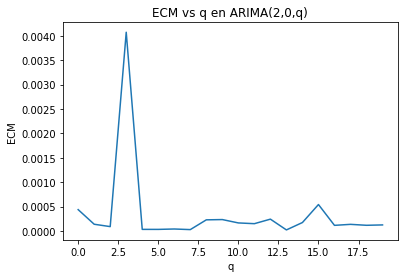

In [25]:
plt.plot(Q, error)
plt.xlabel('q')
plt.ylabel('ECM')
plt.title("ECM vs q en ARIMA(2,0,q)")
plt.savefig('Predicciones/'+'ECM.pdf', bbox_inches = 'tight')

plt.show()

In [26]:
forecast[len(forecast)-4:len(forecast)-1], max(forecast)

(array([0.04090019, 0.04090015, 0.04090011]), 0.10127691123463019)

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


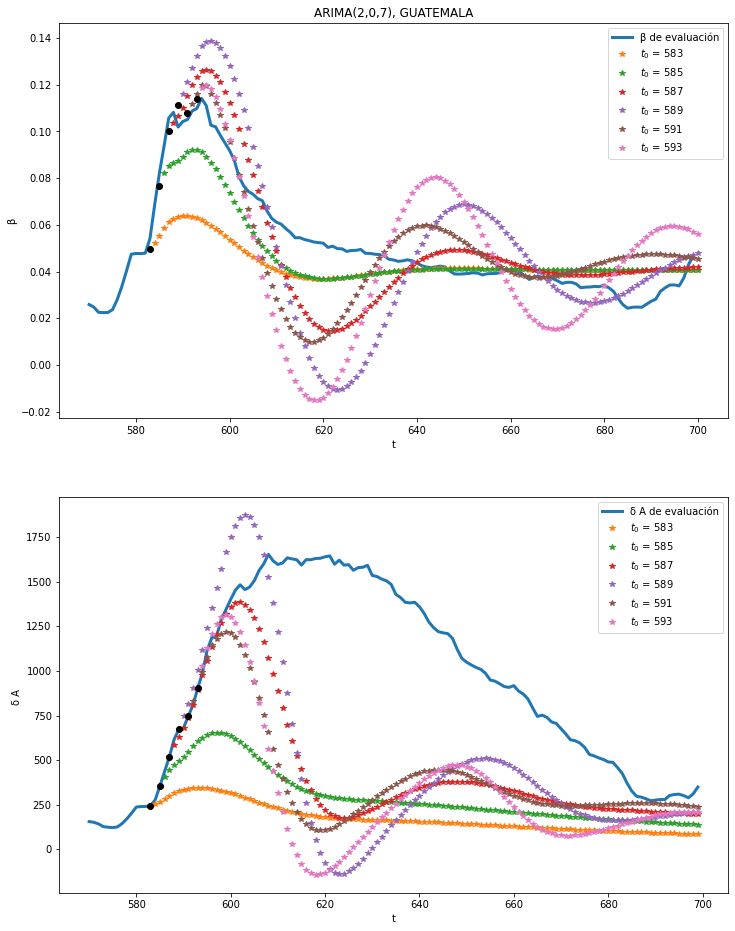

In [27]:
p=2
d=0
q=7
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)

fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = '\u03B2 de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('\u03B2')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = '\u03B4 A de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('\u03B4 A ')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(583, 595,2):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ax[0].plot(t, forecast, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], forecast[0], 'ko')
    ax[0].legend(loc='best')
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], RepDiario[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_ARIMA(2,0,7)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])



In [28]:
def PorcentajeError(p, serie):
    serie = np.array(serie)
    SUP = serie + serie*p/100
    INF = serie - serie*p/100
    sup = SUP.tolist()
    inf = INF.tolist()
    return sup, inf

In [29]:
a=[1,2,3,4]
b, c= PorcentajeError(10,a)
b, c
#ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)

([1.1, 2.2, 3.3, 4.4], [0.9, 1.8, 2.7, 3.6])

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmode

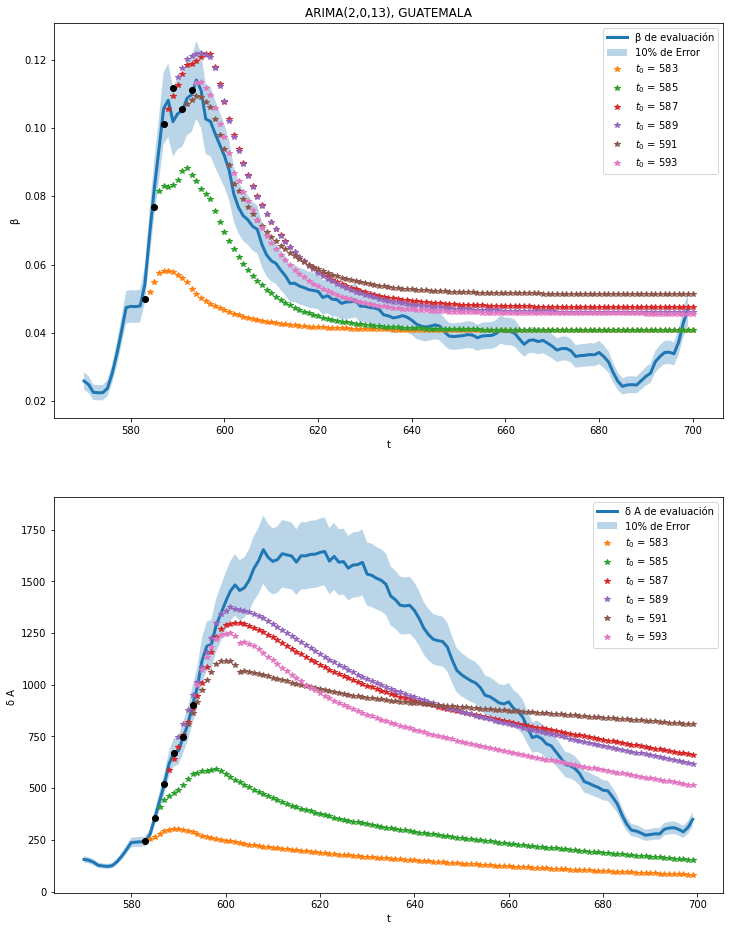

In [30]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)
    
Beta_error_sup, Beta_error_inf = PorcentajeError(10, Beta[0][inicio1:fin1]) 
dA_error_sup, dA_error_inf = PorcentajeError(10, dA[0][inicio1:fin1]) 


fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = '\u03B2 de evaluación')
ax[0].fill_between(t1[:len(t1)-1], Beta_error_inf, Beta_error_sup, alpha=0.3, label = '10% de Error')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('\u03B2')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = '\u03B4 A de evaluación')
ax[1].fill_between(t1[:len(t1)-1], dA_error_inf, dA_error_sup, alpha=0.3, label = '10% de Error')

ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('\u03B4 A ')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(583, 595,2):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ax[0].plot(t, forecast, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], forecast[0], 'ko')
    ax[0].legend(loc='best')
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], RepDiario[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_ARIMA(2,0,13)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/

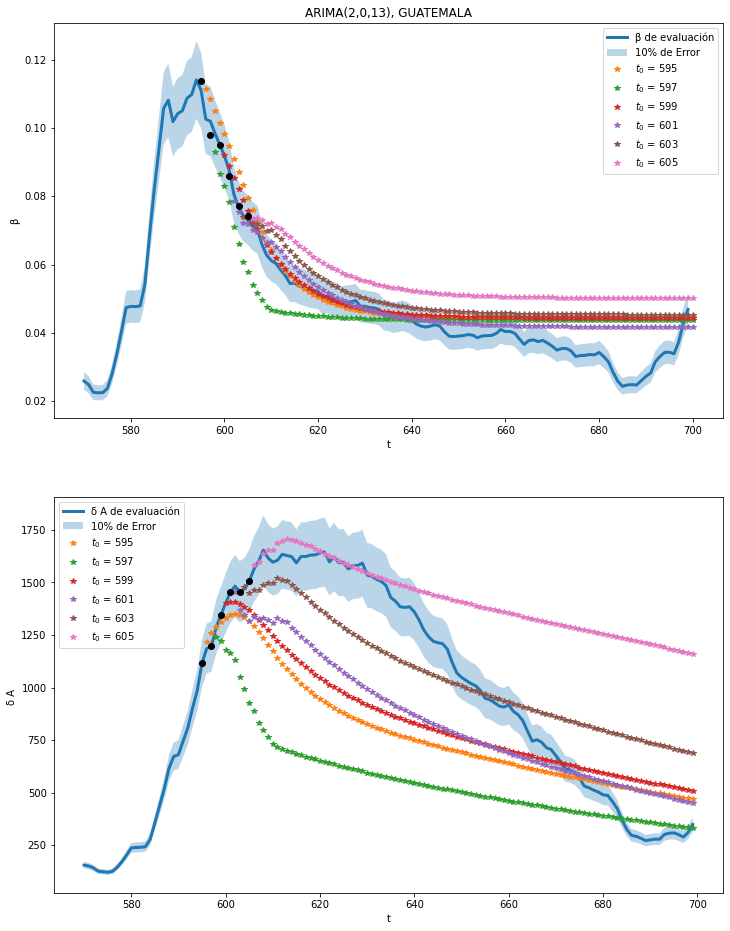

In [31]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)


Beta_error_sup, Beta_error_inf = PorcentajeError(10, Beta[0][inicio1:fin1]) 
dA_error_sup, dA_error_inf = PorcentajeError(10, dA[0][inicio1:fin1])     
    
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],Beta[0][inicio1:fin1], linewidth=3, label = '\u03B2 de evaluación')
ax[0].fill_between(t1[:len(t1)-1], Beta_error_inf, Beta_error_sup, alpha=0.3, label = '10% de Error')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('\u03B2')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[1].plot(t1[:len(t1)-1], dA[0][inicio1:fin1], linewidth=3, label = '\u03B4 A de evaluación')
ax[1].fill_between(t1[:len(t1)-1], dA_error_inf, dA_error_sup, alpha=0.3, label = '10% de Error')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('\u03B4 A ')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(595,606,2):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)
    ax[0].plot(t, forecast, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], forecast[0], 'ko')
    ax[0].legend(loc='best')
    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[1].plot(t[:len(t)-1],RepDiario[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], RepDiario[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Beta_GT_ola3_ARIMA(2,0,13)b.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


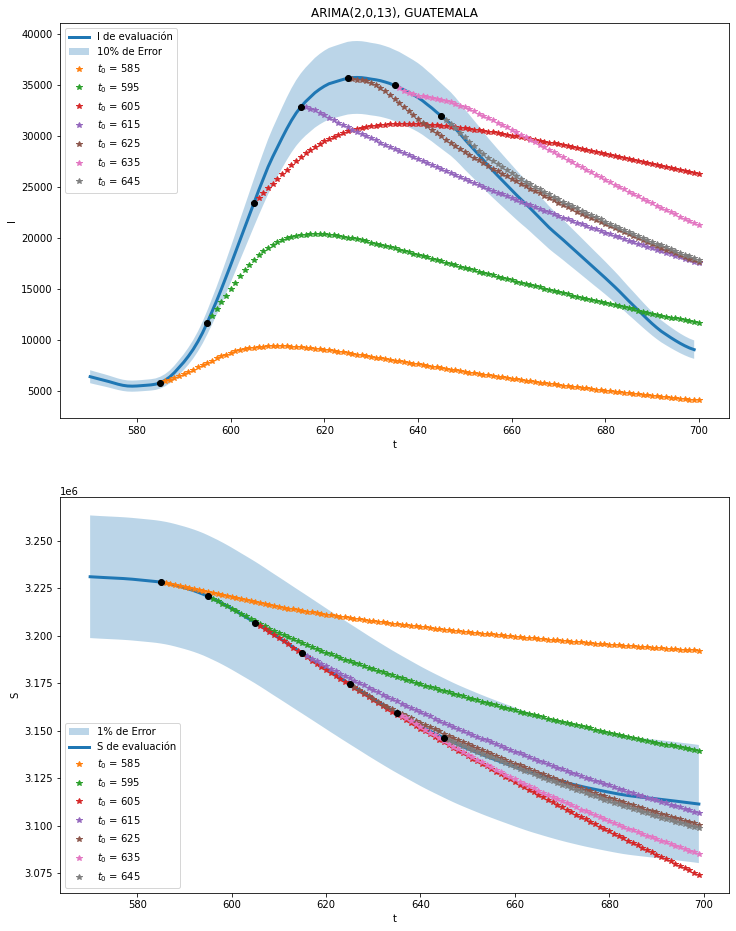

In [32]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)



I_error_sup, I_error_inf = PorcentajeError(10, I[0][inicio1:fin1]) 
S_error_sup, S_error_inf = PorcentajeError(1, S[0][inicio1:fin1])     
        
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],I[0][inicio1:fin1], linewidth=3, label = 'I de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('I')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], I_error_inf, I_error_sup, alpha=0.3, label = '10% de Error')
ax[1].fill_between(t1[:len(t1)-1], S_error_inf, S_error_sup, alpha=0.3, label = '1% de Error')

ax[1].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('S')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(585,646,10):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Infectados, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Infectados[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],Sucept[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], Sucept[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Infectados_GT_ola3_ARIMA(2,0,13)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])
#son confiables dentro del 1% al menos durante 1 mes

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


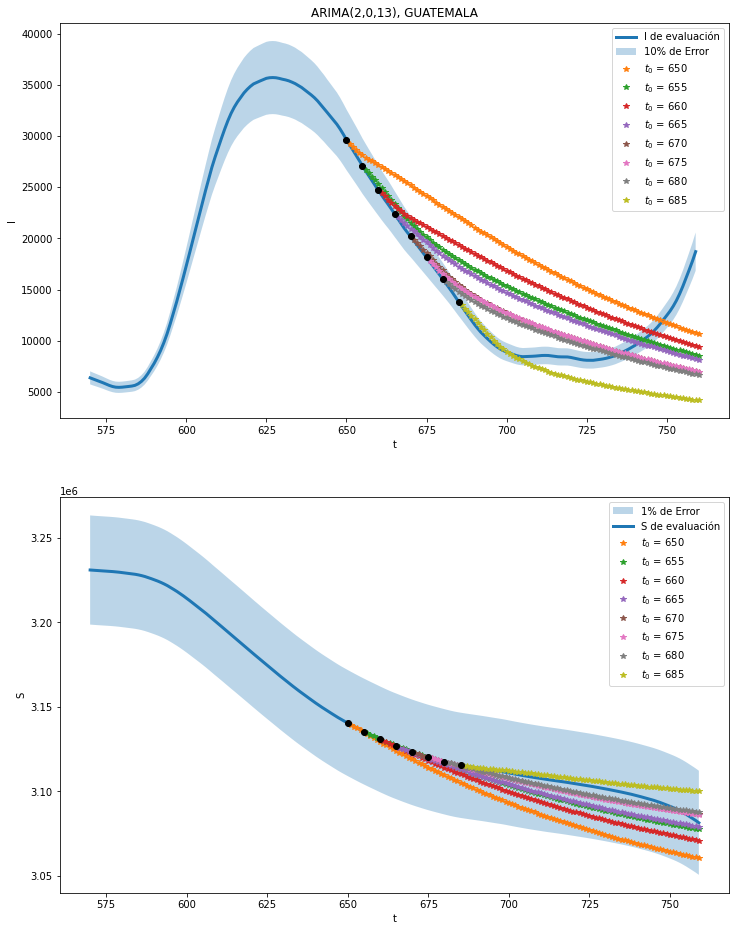

In [33]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 160
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)
    
    


I_error_sup, I_error_inf = PorcentajeError(10, I[0][inicio1:fin1]) 
S_error_sup, S_error_inf = PorcentajeError(1, S[0][inicio1:fin1])    

fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],I[0][inicio1:fin1], linewidth=3, label = 'I de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('I')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], I_error_inf, I_error_sup, alpha=0.3, label = '10% de Error')
ax[1].fill_between(t1[:len(t1)-1], S_error_inf, S_error_sup, alpha=0.3, label = '1% de Error')

ax[1].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('S')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(650,686, 5):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Infectados, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Infectados[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],Sucept[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], Sucept[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_Infectados_GT_ola3_ARIMA(2,0,13)b.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


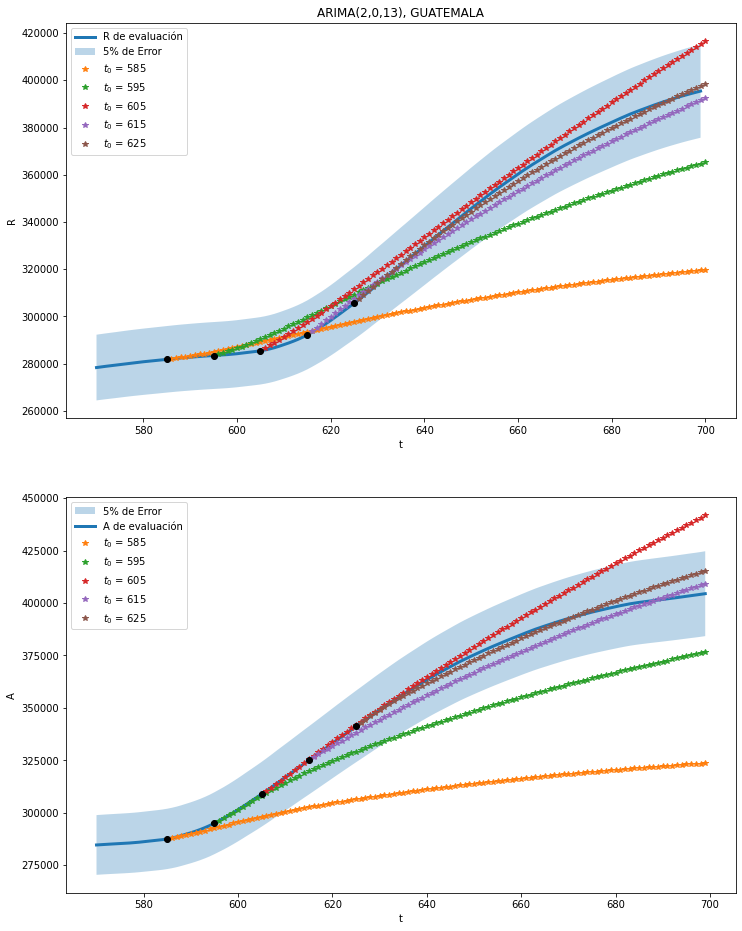

In [34]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)

    


R_error_sup, R_error_inf = PorcentajeError(5, R[0][inicio1:fin1]) 
A_error_sup, A_error_inf = PorcentajeError(5, A[0][inicio1:fin1])    
    
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],R[0][inicio1:fin1], linewidth=3, label = 'R de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('R')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], R_error_inf, R_error_sup, alpha=0.3, label = '5% de Error')
ax[1].fill_between(t1[:len(t1)-1], A_error_inf, A_error_sup, alpha=0.3, label = '5% de Error')

ax[1].plot(t1[:len(t1)-1], A[0][inicio1:fin1], linewidth=3, label = 'A de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('A')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(585,626,10):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Removidos, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Removidos[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],ACUMULADO[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], ACUMULADO[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_ACUMULADOS_GT_ola3_ARIMA(2,0,13)a.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


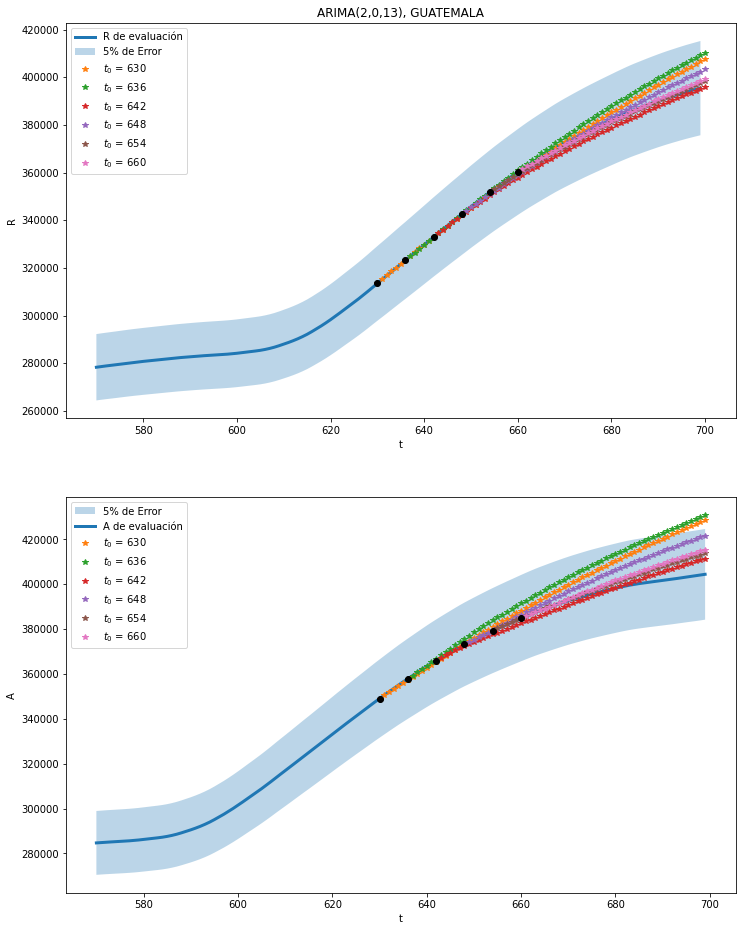

In [35]:
p=2
d=0
q=13
###################
inicio1 = 570
fin1 = 600 + 100
t1 = []
for i in range(inicio1, fin1+1):
    t1.append(i)

R_error_sup, R_error_inf = PorcentajeError(5, R[0][inicio1:fin1]) 
A_error_sup, A_error_inf = PorcentajeError(5, A[0][inicio1:fin1])    
    
    
fig, ax = plt.subplots(2,1,figsize=(12,16))
ax[0].plot(t1[:len(t1)-1],R[0][inicio1:fin1], linewidth=3, label = 'R de evaluación')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('R')
ax[0].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+'), '+ NOMBREDEPTO[0])

ax[0].fill_between(t1[:len(t1)-1], R_error_inf, R_error_sup, alpha=0.3, label = '5% de Error')
ax[1].fill_between(t1[:len(t1)-1], A_error_inf, A_error_sup, alpha=0.3, label = '5% de Error')

ax[1].plot(t1[:len(t1)-1], A[0][inicio1:fin1], linewidth=3, label = 'A de evaluación')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('A')
    #ax[1].set_title('ARIMA('+str(p)+','+str(d)+','+str(q)+')'+ NOMBREDEPTO[0])

    #ax[2].plot(t1[:len(t1)-1], I[0][inicio1:fin1], linewidth=3, label = 'I Observado')
    #ax[2].legend()
    #ax[3].plot(t1[:len(t1)-1], S[0][inicio1:fin1], linewidth=3, label = 'S Observado')
    #ax[3].legend()

for i in range(630,661,6):
    inicio = i
    fin = fin1
    t= []
    for i in range(inicio, fin+1):
        t.append(i)
    model=ARIMA(Beta[0][:inicio],order=(p,d,q))
    #  d=0 porque ya es estacionario, no necesito diferencias
    model_fit=model.fit()
    model_fit.summary()

    forecast = model_fit.predict(start=inicio,end=fin,dynamic=True)

    I0,S0,R0,BetaCoef,n,dA0,A0, gamma = I[0][inicio],S[0][inicio],R[0][inicio], forecast, 0, dA[0][inicio], A[0][inicio], 1./21.,  
    T= fin-inicio
    dt=1
    Infectados, Sucept, Removidos, ACUMULADO, RepDiario = DifFinitas2(I0,S0,R0,BetaCoef,n,Poblacion,dA0,A0, gamma, T, dt)

    ax[0].plot(t, Removidos, '*', label='$t_{0}$ = ' + str(inicio))
    ax[0].plot(t[0], Removidos[0], 'ko')
    ax[0].legend(loc='best')

    ax[1].plot(t[:len(t)-1],ACUMULADO[:len(t)-1], '*', label='$t_{0}$ = ' + str(inicio) )
    ax[1].plot(t[0], ACUMULADO[0], 'ko')
    ax[1].legend(loc='best')
        
    
plt.savefig('Predicciones/'+'Predicciones_ACUMULADOS_GT_ola3_ARIMA(2,0,13)b.pdf', bbox_inches = 'tight')

    #    ax[2].plot(t[:len(t)-1],Infectados[:len(t)-1])
    #    ax[3].plot(t[:len(t)-1],Sucept[:len(t)-1])


In [36]:
model=ARIMA(Beta[0][:630],order=(2,0,13)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  630
Model:                ARIMA(2, 0, 13)   Log Likelihood                3219.390
Date:                Sat, 06 May 2023   AIC                          -6404.780
Time:                        11:47:57   BIC                          -6329.203
Sample:                             0   HQIC                         -6375.424
                                - 630                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0459      0.004     12.067      0.000       0.038       0.053
ar.L1          0.9492      0.164      5.783      0.000       0.628       1.271
ar.L2         -0.0327      0.159     -0.206      0.836      -0.344       0.278
ma.L1          0.4618      0.162      2.843      0.004       0.143       0.780
ma.L2          0.3080      0.078      3.942      0.000       0.155       0.461
ma.L3          0.2920      0.054      5.370      0.000       0.185       0.399
ma.L4          0.2238      0.046      4.859      0.000       0.134       0.314
ma.L5          0.1511      0.043      3.507      0.000       0.067       0.235
ma.L6          0.3160      0.035      9.076      0.000       0.248       0.384
ma.L7          0.5958      0.041     14.669      0.000       0.516       0.675
ma.L8          0.5222      0.095      5.469      0.000       0.335       0.709
ma.L9          0.3830      0.082      4.679      0.000       0.223       0.543
ma.L10         0.3358      0.065      5.137      0.000       0.208       0.464
ma.L11         0.2252      0.053      4.231      0.000       0.121       0.330
ma.L12         0.1011      0.047      2.165      0.030       0.010       0.193
ma.L13         0.2450      0.043      5.682      0.000       0.160       0.330
sigma2      2.098e-06   8.73e-08     24.028      0.000    1.93e-06    2.27e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):               750.32
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                             0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
model=ARIMA(Beta[0][:585],order=(2,0,13)) #d=0 porque ya es estacionario, no necesito diferencias
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  585
Model:                ARIMA(2, 0, 13)   Log Likelihood                3018.818
Date:                Sat, 06 May 2023   AIC                          -6003.635
Time:                        11:48:02   BIC                          -5929.318
Sample:                             0   HQIC                         -5974.672
                                - 585                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0408      0.004     11.499      0.000       0.034       0.048
ar.L1          0.9497      0.170      5.580      0.000       0.616       1.283
ar.L2         -0.0395      0.163     -0.242      0.809      -0.359       0.280
ma.L1          0.4206      0.177      2.382      0.017       0.075       0.767
ma.L2          0.2094      0.082      2.566      0.010       0.049       0.369
ma.L3          0.1618      0.046      3.500      0.000       0.071       0.252
ma.L4          0.1803      0.038      4.719      0.000       0.105       0.255
ma.L5          0.2126      0.053      4.030      0.000       0.109       0.316
ma.L6          0.3726      0.046      8.150      0.000       0.283       0.462
ma.L7          0.5194      0.060      8.715      0.000       0.403       0.636
ma.L8          0.4614      0.088      5.267      0.000       0.290       0.633
ma.L9          0.3138      0.084      3.743      0.000       0.150       0.478
ma.L10         0.2786      0.064      4.352      0.000       0.153       0.404
ma.L11         0.1904      0.066      2.866      0.004       0.060       0.321
ma.L12         0.1560      0.055      2.861      0.004       0.049       0.263
ma.L13         0.2617      0.047      5.523      0.000       0.169       0.355
sigma2      1.888e-06    8.9e-08     21.214      0.000    1.71e-06    2.06e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               631.92
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
def AR(phi1, phi2, b1, b0):
    b = phi1*b0 + phi2*b1
    return b

In [39]:
t0 =640
Predicciones = []
phi1 = 0.9553
phi2 = -0.0383
b0 = Beta[0][t0]
b1 = Beta[0][t0+1]
Predicciones.append(b0)
Predicciones.append(b1)

for i in range(2,50):
    b_i = AR(phi1, phi2, Beta[0][t0+i-1], Beta[0][t0+i-2])
    Predicciones.append(b_i)

